In [1]:
%load_ext autoreload
%autoreload 2

import helper
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten, Dropout, Dense
from keras import optimizers
%matplotlib inline


Using TensorFlow backend.


# Read in data, format, & preprocess

In [2]:
emotion_dict = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
image_shape = (48,48,1)
n_classes = len(emotion_dict)
n_features = np.product(image_shape)

In [3]:
# read in data
file_path = './Data/Kaggle-FER/fer2013.csv'
data_raw = helper.read_in_data(file_path) # data is a tuple of (x_list, y_list, usage_list)

In [4]:
# convert data to numpy array
data_formatted = helper.format(data_raw, image_shape, n_classes) # return tuple of (x_array, y_array, usage_list)

In [5]:
# number of example for each class
label, count = np.unique(data_formatted[1], return_counts=True)
dict(zip(label, count))

{0: 4945, 1: 547, 2: 5121, 3: 8988, 4: 6076, 5: 4001, 6: 6197}

In [6]:
# split into train & test sets. Test set = public, private set is used for final testing, to be consistent with the competition
(x_train, y_train), (x_test, y_test), (x_private, y_private) = helper.create_train_test(data_formatted, n_classes)

In [7]:
# one-hot encode
y_train_onehot = keras.utils.to_categorical(y_train, n_classes)
y_test_onehot = keras.utils.to_categorical(y_test, n_classes)
y_private_onehot = keras.utils.to_categorical(y_private, n_classes)

In [8]:
print(x_train.shape)
print(y_train.shape)
print(y_train_onehot.shape)
print(x_test.shape)
print(y_test.shape)
print(y_test_onehot.shape)
print(x_private.shape)
print(y_private.shape)
print(y_private_onehot.shape)

(28698, 48, 48, 1)
(28698, 1)
(28698, 7)
(3588, 48, 48, 1)
(3588, 1)
(3588, 7)
(3589, 48, 48, 1)
(3589, 1)
(3589, 7)


In [9]:
# preprocess: normalized
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(x_test)


C:\Program Files (x86)\Python35-64bit\lib\site-packages\keras\preprocessing\image.py:648: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
C:\Program Files (x86)\Python35-64bit\lib\site-packages\keras\preprocessing\image.py:648: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (3588, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


happy


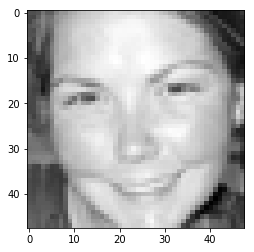

In [10]:
# visual data
index = 8

img_array = np.reshape(x_train[index], (48,48))
plt.imshow(img_array, cmap='gray')
print(emotion_dict[y_train[index,0]])

# after preprocess
i = 0
for batch in train_datagen.flow(np.reshape(x_train[index], (1,*image_shape))
                                , batch_size=32, save_to_dir='preview', save_format='jpeg'):
    i += 1
    if i > 20:
        break

# Build model

In [11]:
# simple model
model = Sequential()
model.add(Conv2D(20, (4,4), padding='same', activation='relu', input_shape=image_shape))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid'))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 20)        340       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 20)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11520)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1152100   
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 707       
Total params: 1,153,147
Trainable params: 1,153,147
Non-trainable params: 0
_________________________________________________________________


In [12]:
adam = optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# train

In [13]:
epochs = 100
batch_size = 256
n_train = len(x_train)
n_test = len(x_test)

In [14]:
model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size)

Epoch 1/100
112/112 [==============================] - 40s - loss: 1.7177 - acc: 0.3333 - val_loss: 1.5945 - val_acc: 0.3892
Epoch 2/100
112/112 [==============================] - 38s - loss: 1.5364 - acc: 0.4175 - val_loss: 1.5084 - val_acc: 0.4172
Epoch 3/100
112/112 [==============================] - 38s - loss: 1.4574 - acc: 0.4489 - val_loss: 1.4496 - val_acc: 0.4400
Epoch 4/100
112/112 [==============================] - 38s - loss: 1.4048 - acc: 0.4686 - val_loss: 1.4296 - val_acc: 0.4577
Epoch 5/100
112/112 [==============================] - 39s - loss: 1.3629 - acc: 0.4877 - val_loss: 1.3948 - val_acc: 0.4745
Epoch 6/100
112/112 [==============================] - 38s - loss: 1.3274 - acc: 0.5016 - val_loss: 1.3927 - val_acc: 0.4696
Epoch 7/100
112/112 [==============================] - 38s - loss: 1.2848 - acc: 0.5197 - val_loss: 1.3920 - val_acc: 0.4682
Epoch 8/100
112/112 [==============================] - 38s - loss: 1.2602 - acc: 0.5255 - val_loss: 1.3830 - val_acc: 0.4730


112/112 [==============================] - 36s - loss: 0.6032 - acc: 0.7764 - val_loss: 1.9102 - val_acc: 0.4849
Epoch 67/100
112/112 [==============================] - 37s - loss: 0.6025 - acc: 0.7792 - val_loss: 1.9429 - val_acc: 0.4748
Epoch 68/100
112/112 [==============================] - 36s - loss: 0.5919 - acc: 0.7815 - val_loss: 1.9306 - val_acc: 0.4814
Epoch 69/100
112/112 [==============================] - 36s - loss: 0.5897 - acc: 0.7811 - val_loss: 1.9652 - val_acc: 0.4769
Epoch 70/100
112/112 [==============================] - 36s - loss: 0.5802 - acc: 0.7887 - val_loss: 1.9732 - val_acc: 0.4742
Epoch 71/100
112/112 [==============================] - 36s - loss: 0.5862 - acc: 0.7829 - val_loss: 1.9728 - val_acc: 0.4718
Epoch 72/100
112/112 [==============================] - 36s - loss: 0.5732 - acc: 0.7870 - val_loss: 2.0066 - val_acc: 0.4748
Epoch 73/100
112/112 [==============================] - 36s - loss: 0.5784 - acc: 0.7869 - val_loss: 2.0022 - val_acc: 0.4805
Epoch

In [15]:
# save and evaluate model
model.save_weights('./Model/simple model_epoch100.h5')
model.evaluate_generator(test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size), steps=batch_size)

[2.2395591638962347, 0.47877620322601711]

In [16]:
# test model
test_datagen.fit(x_private)
model.evaluate_generator(test_datagen.flow(x_private, y_private_onehot, batch_size=batch_size), steps=batch_size)

C:\Program Files (x86)\Python35-64bit\lib\site-packages\keras\preprocessing\image.py:648: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (3589, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


[2.1483092521727705, 0.49375703864288545]